In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pickle
from pathlib import Path
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
from tensorflow import keras
from keras import Sequential, Model
from keras.layers import Dense, Dropout, Activation, \
Flatten, Input, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,BatchNormalization, Dropout
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

from keras.metrics import CategoricalAccuracy, Recall, Precision
from tensorflow_addons.metrics import F1Score

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32

In [ ]:
LABELS = ["ForwardFall", "BackwardFall", "LeftFall", "RightFall", "GetDown", "SitDown", "Walk"]
LABEL2INDEX = dict(zip(LABELS, range(len(LABELS))))
INDEX2LABEL = dict(zip(range(len(LABELS)), LABELS))

In [ ]:
def build_model(img_height=IMAGE_HEIGHT, img_width=IMAGE_WIDTH, initial_filter=2**5,num_classes=7):
  model = Sequential()
  # First
  model.add(Conv2D(filters=initial_filter, kernel_size=(3, 3),
                   activation=tf.nn.relu,
                   input_shape=(img_height, img_width, 1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  # Second
  model.add(Conv2D(filters=initial_filter * 2, kernel_size=(3, 3),
                   activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  # Third
  model.add(Conv2D(filters=initial_filter * 2**2, kernel_size=(3, 3),
                   activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.5))

  model.add(Dense(50, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.5))
  model.add(Dense(num_classes, activation=tf.nn.softmax))

  model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=[
                    CategoricalAccuracy(name='categorical_acc'),
                    Precision(name='pre'),
                    Recall(name='recall'),
                    F1Score(num_classes=num_classes, average='weighted', name='f1')
                ])

  return model

In [ ]:
def load_dataset(ds_name):
  with open(ds_name + '/element_spec', 'rb') as in_:
    es = pickle.load(in_)

  dataset = tf.data.Dataset.load(
      ds_name, es, compression='GZIP'
  )
  return dataset

# 7 labels

In [ ]:
train_ds = load_dataset("train")
val_ds = load_dataset("val")
test_ds = load_dataset("test")

In [ ]:
train_size = len(train_ds)
val_size = len(val_ds)
test_size = len(test_ds)
print(f'Train Size: {train_size}\nValidation Size: {val_size}\nTest Size: {test_size}')

Train Size: 65399
Validation Size: 26174
Test Size: 17182


In [ ]:
def one_hot_encode_label(label):
  label = tf.cast(label, dtype=tf.int32)
  return tf.one_hot(label, depth=7)

def process_image(image):
  image = image/255.0
  return image

train_ds = train_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))
val_ds = val_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))
test_ds = test_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().batch(batch_size=2**9).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size=2**9).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size=2**9).prefetch(buffer_size=AUTOTUNE)

In [ ]:
cnn_model = build_model(num_classes=7)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 15, 15, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                        

In [ ]:
today = str(datetime.date.today())
f1_modelcheckpoint_callback = ModelCheckpoint(
    today + 'cnn_model',
    monitor='val_f1',
    verbose=1,
    save_best_only=True,
    mode='max'
)

f1_early_stopping_callback = EarlyStopping(
    monitor='val_f1',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = cnn_model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[
        f1_modelcheckpoint_callback,
        f1_early_stopping_callback
    ]
)

Epoch 1/30
128/128 [==============================] - ETA: 0s - loss: 2.6159 - categorical_acc: 0.2352 - pre: 0.2755 - recall: 0.1108 - f1: 0.2320
Epoch 1: val_f1 improved from -inf to 0.11817, saving model to 2024-04-14cnn_model
128/128 [==============================] - 39s 194ms/step - loss: 2.6159 - categorical_acc: 0.2352 - pre: 0.2755 - recall: 0.1108 - f1: 0.2320 - val_loss: 2.3262 - val_categorical_acc: 0.2611 - val_pre: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.1182
Epoch 2/30
125/128 [============================>.] - ETA: 0s - loss: 2.0049 - categorical_acc: 0.3705 - pre: 0.4689 - recall: 0.1714 - f1: 0.3669
Epoch 2: val_f1 improved from 0.11817 to 0.20193, saving model to 2024-04-14cnn_model
128/128 [==============================] - 6s 44ms/step - loss: 1.9958 - categorical_acc: 0.3724 - pre: 0.4720 - recall: 0.1729 - f1: 0.3687 - val_loss: 2.2696 - val_categorical_acc: 0.3235 - val_pre: 1.0000 - val_recall: 4.5847e-04 - val_f1: 0.2019
Epoch 3/30
125/128 [===========

dict_keys(['loss', 'categorical_acc', 'pre', 'recall', 'f1', 'val_loss', 'val_categorical_acc', 'val_pre', 'val_recall', 'val_f1'])


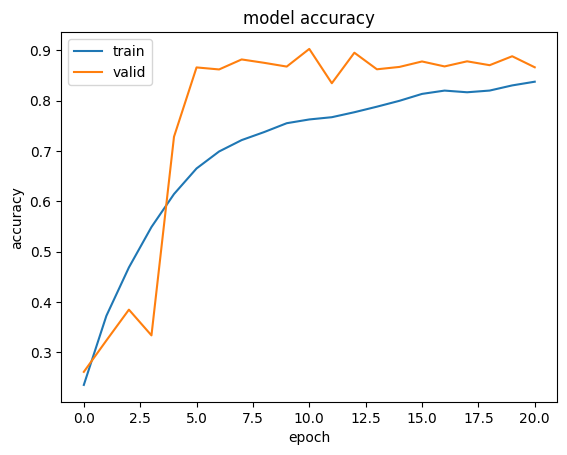

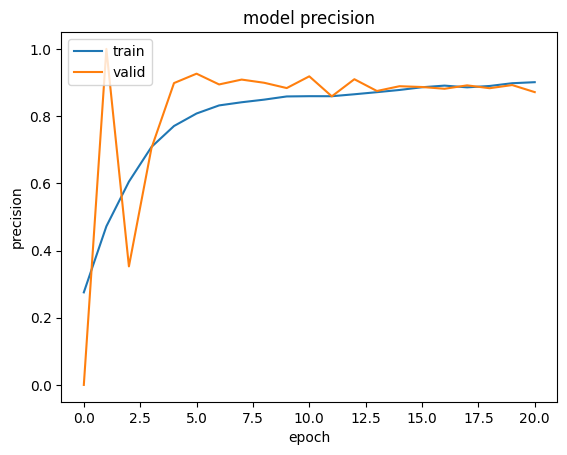

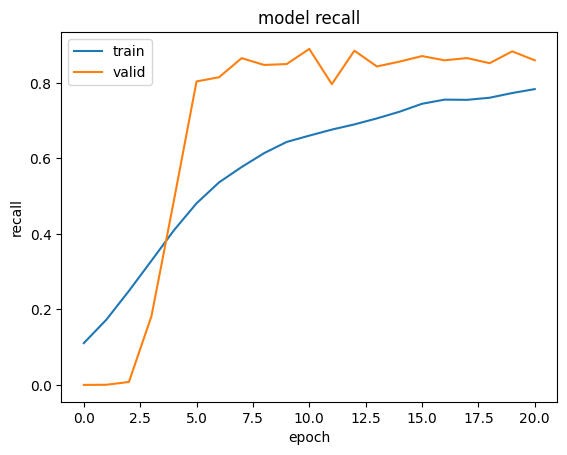

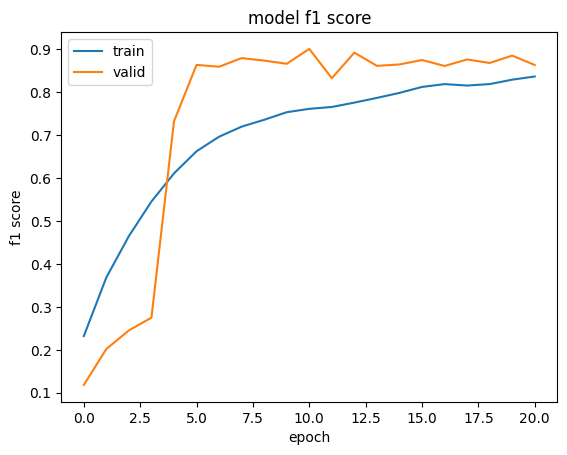

In [ ]:
print(history.history.keys())
plt.plot(history.history['categorical_acc'])
plt.plot(history.history['val_categorical_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history.history['pre'])
plt.plot(history.history['val_pre'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
print(cnn_model.evaluate(val_ds))

52/52 [==============================] - 0s 6ms/step - loss: 0.4660 - categorical_acc: 0.9027 - pre: 0.9184 - recall: 0.8902 - f1: 0.9011
[0.46597418189048767, 0.9027279019355774, 0.9184043407440186, 0.8901581764221191, 0.9010674953460693]


In [ ]:
print(cnn_model.evaluate(test_ds))

34/34 [==============================] - 2s 64ms/step - loss: 0.5899 - categorical_acc: 0.8710 - pre: 0.9008 - recall: 0.8569 - f1: 0.8587
[0.5898768901824951, 0.8710278272628784, 0.9007708430290222, 0.8569433093070984, 0.8587125539779663]


In [ ]:
y_pred = []
y_true = []

for image_batch, label_batch in val_ds:
   y_true.append(label_batch)
   preds = cnn_model.predict(image_batch, verbose=0)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
conf_matrix = confusion_matrix(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy())
confusion_df = pd.DataFrame(conf_matrix, index=LABELS, columns=LABELS)
display(confusion_df)
f1_score(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy(), average=None)

,ForwardFall,BackwardFall,LeftFall,RightFall,GetDown,SitDown,Walk
ForwardFall,3771,243,0,1,0,0,0
BackwardFall,1063,2714,143,0,0,0,0
LeftFall,6,0,3101,114,0,156,157
RightFall,0,0,149,3405,0,1,51
GetDown,0,0,5,0,3573,35,1
SitDown,0,0,0,0,0,3585,0
Walk,0,0,123,0,298,0,3479


array([0.85172219, 0.78929766, 0.87909284, 0.95565535, 0.95470942,
       0.97392013, 0.91697417])

# 2 labels

In [ ]:
train_ds = load_dataset("train")
val_ds = load_dataset("val")
test_ds = load_dataset("test")

In [ ]:
def process_image(image):
  image = image/255.0
  return image

def one_hot_encode_label(label):
  label = tf.cast(label, dtype=tf.int32)
  label = int(label<=3)
  return tf.one_hot(label, depth=2)

train_ds = train_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))
val_ds = val_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))
test_ds = test_ds.map(lambda x, y: (process_image(x), one_hot_encode_label(y)))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().batch(batch_size=2**9).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size=2**9).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size=2**9).prefetch(buffer_size=AUTOTUNE)

In [ ]:
cnn_model = build_model(num_classes=2)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Bat  (None, 15, 15, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                      

In [ ]:
today = str(datetime.date.today())
f1_modelcheckpoint_callback = ModelCheckpoint(
    today + 'cnn_model',
    monitor='val_f1',
    verbose=1,
    save_best_only=True,
    mode='max'
)

f1_early_stopping_callback = EarlyStopping(
    monitor='val_f1',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = cnn_model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[
        f1_modelcheckpoint_callback,
        f1_early_stopping_callback,
    ]
)

Epoch 1/30
128/128 [==============================] - ETA: 0s - loss: 0.9998 - categorical_acc: 0.6888 - pre: 0.6888 - recall: 0.6888 - f1: 0.6897
Epoch 1: val_f1 improved from -inf to 0.42098, saving model to 2024-04-14cnn_model
128/128 [==============================] - 15s 90ms/step - loss: 0.9998 - categorical_acc: 0.6888 - pre: 0.6888 - recall: 0.6888 - f1: 0.6897 - val_loss: 0.9281 - val_categorical_acc: 0.5760 - val_pre: 0.5760 - val_recall: 0.5760 - val_f1: 0.4210
Epoch 2/30
126/128 [============================>.] - ETA: 0s - loss: 0.7490 - categorical_acc: 0.7666 - pre: 0.7666 - recall: 0.7666 - f1: 0.7664
Epoch 2: val_f1 did not improve from 0.42098
128/128 [==============================] - 2s 18ms/step - loss: 0.7440 - categorical_acc: 0.7694 - pre: 0.7694 - recall: 0.7694 - f1: 0.7692 - val_loss: 0.8481 - val_categorical_acc: 0.5760 - val_pre: 0.5760 - val_recall: 0.5760 - val_f1: 0.4210
Epoch 3/30
128/128 [==============================] - ETA: 0s - loss: 0.6563 - catego

dict_keys(['loss', 'categorical_acc', 'pre', 'recall', 'f1', 'val_loss', 'val_categorical_acc', 'val_pre', 'val_recall', 'val_f1'])


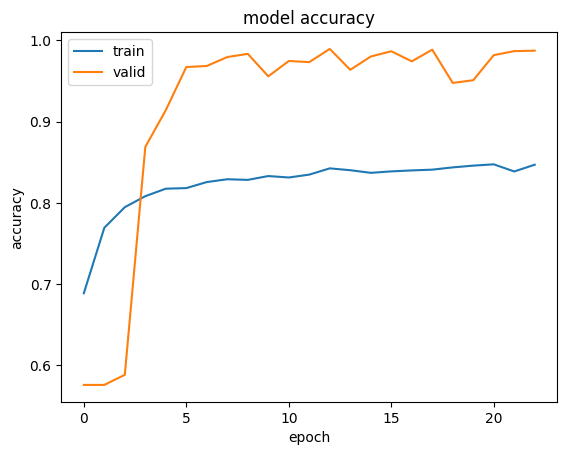

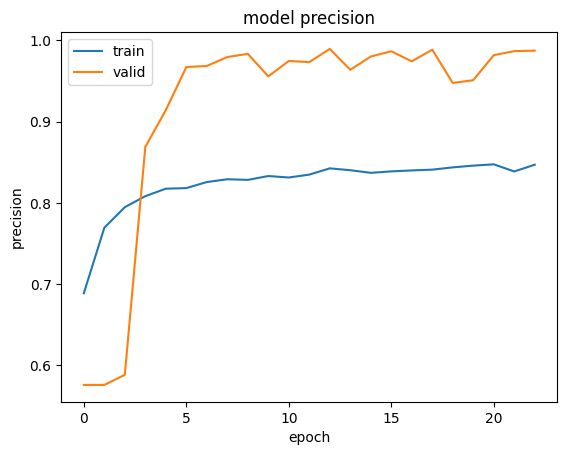

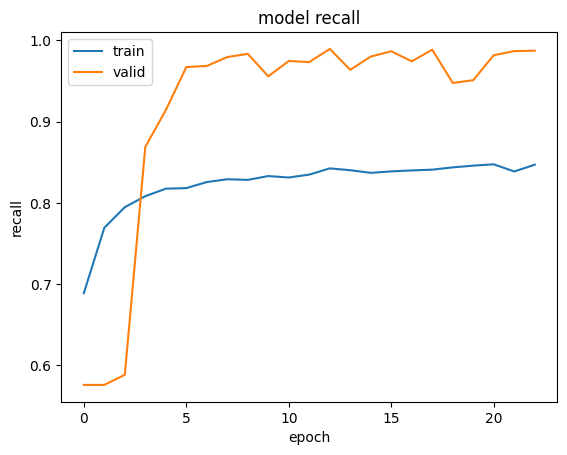

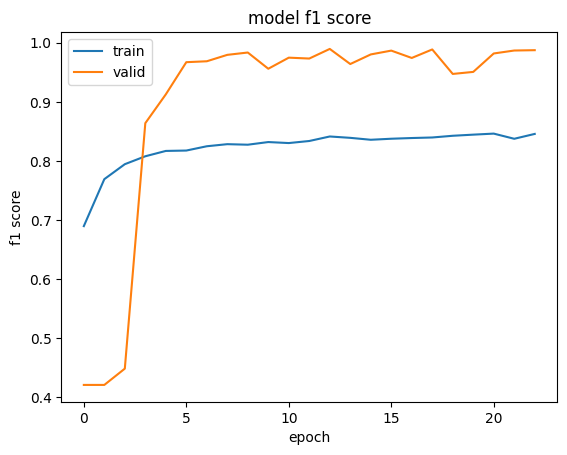

In [ ]:
print(history.history.keys())
plt.plot(history.history['categorical_acc'])
plt.plot(history.history['val_categorical_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history.history['pre'])
plt.plot(history.history['val_pre'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
print(cnn_model.evaluate(val_ds))

52/52 [==============================] - 1s 9ms/step - loss: 0.1499 - categorical_acc: 0.9896 - pre: 0.9896 - recall: 0.9896 - f1: 0.9896
[0.14992180466651917, 0.9895697832107544, 0.9895697832107544, 0.9895697832107544, 0.989567756652832]


In [ ]:
print(cnn_model.evaluate(test_ds))

34/34 [==============================] - 1s 34ms/step - loss: 0.1381 - categorical_acc: 0.9895 - pre: 0.9895 - recall: 0.9895 - f1: 0.9895
[0.13814093172550201, 0.9895239472389221, 0.9895239472389221, 0.9895239472389221, 0.9895108938217163]


In [ ]:
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
   y_true.append(label_batch)
   preds = cnn_model.predict(image_batch, verbose=0)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
conf_matrix = confusion_matrix(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy())
confusion_df = pd.DataFrame(conf_matrix, index=["Not Fall", "Fall"], columns=["Not Fall", "Fall"])
display(confusion_df)
f1_score(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy(), average=None)

,Not Fall,Fall
Not Fall,7482,179
Fall,1,9520


array([0.9881141 , 0.99063476])